<a href="https://colab.research.google.com/github/ZealPower22/Instagram_sentiment_Analysis/blob/main/Instagram_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji faker tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.9 MB/s eta 0:00:00


In [ ]:
!

In [ ]:
# DATASET GENERATION
import pandas as pd
import random
import emoji
from faker import Faker
from tqdm import tqdm  # For progress bar

# Initialize Faker
fake = Faker()

# Predefined sentiment words
positive_words = ["amazing", "love", "awesome", "fantastic", "great", "😍", "🔥", "💖", "LOL", "LMAO"]
negative_words = ["worst", "terrible", "hate", "awful", "bad", "😡", "😢", "💔", "WTF", "IDK"]
neutral_words = ["okay", "fine", "alright", "not bad", "hmm", "🤔", "🙂", "😐", "IDK", "meh"]

# Common abbreviations & slang
abbreviations = ["OMG", "LOL", "IDK", "TTYL", "BRB", "SMH", "FOMO", "ICYMI", "GTG", "FYI"]

# Hashtags and entities
hashtags = ["#fun", "#awesome", "#sad", "#trending", "#viral", "#instagram", "#mood", "#OOTD", "#FYP"]
brands = ["Nike", "Adidas", "Apple", "Samsung", "Tesla", "McDonald's", "Coca-Cola"]
celebrities = ["Elon Musk", "Taylor Swift", "Cristiano Ronaldo", "Billie Eilish", "Drake"]
locations = ["NYC", "LA", "Paris", "Tokyo", "London", "Dubai"]

# Generate a random comment with abbreviations and entities
def generate_comment(sentiment):
    comment = fake.sentence()

    if sentiment == "Positive":
        comment += f" {random.choice(positive_words)} {random.choice(positive_words)}"
    elif sentiment == "Negative":
        comment += f" {random.choice(negative_words)} {random.choice(negative_words)}"
    else:
        comment += f" {random.choice(neutral_words)} {random.choice(neutral_words)}"

    # Add abbreviations
    if random.random() > 0.5:
        comment += f" {random.choice(abbreviations)}"

    # Add brand, celebrity, or location
    if random.random() > 0.5:
        comment += f" @{random.choice(celebrities)}" if random.random() > 0.5 else f" #{random.choice(hashtags)}"

    return comment

# Define number of records
num_samples = 1_000_000  # 1 Million Records
batch_size = 100_000  # Save in batches to avoid memory issues

# Open CSV file
csv_filename = "large_instagram_sentiment_dataset.csv"
with open(csv_filename, "w", encoding="utf-8") as file:
    file.write("Comment,Sentiment,Likes,Replies\n")  # Write header

# Generate data in batches
for batch in tqdm(range(num_samples // batch_size), desc="Generating Data"):
    data = []
    for _ in range(batch_size):
        sentiment = random.choice(["Positive", "Negative", "Neutral"])
        comment = generate_comment(sentiment)
        likes = random.randint(0, 5000)  # Simulating viral posts
        replies = random.randint(0, 200)  # Simulating engagement

        data.append([comment, sentiment, likes, replies])

    # Save batch to CSV
    df = pd.DataFrame(data, columns=["Comment", "Sentiment", "Likes", "Replies"])
    df.to_csv(csv_filename, mode="a", index=False, header=False)  # Append data

print(f"✅ Dataset saved as '{csv_filename}' with 1 million entries!")


Generating Data: 100%|██████████| 10/10 [00:43<00:00,  4.35s/it]

✅ Dataset saved as 'large_instagram_sentiment_dataset.csv' with 1 million entries!


In [ ]:
#TF-IDF vectorizer, Naive bayes, logistic regression

import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords

# Download stopwords for text processing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load dataset (Generated dataset with 1 million entries)
df = pd.read_csv("large_instagram_sentiment_dataset.csv")

# Display dataset structure
print(df.head())

# Data Preprocessing Function
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'@\w+|#\w+|http\S+', '', text)  # Remove mentions, hashtags, URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply preprocessing
df['Cleaned_Comment'] = df['Comment'].apply(preprocess_text)

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_Comment'])

# Convert Sentiment Labels to Numerical Format
df['Sentiment'] = df['Sentiment'].map({"Positive": 1, "Negative": -1, "Neutral": 0})

# Split dataset into training & testing
X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiment'], test_size=0.2, random_state=42)

# Train a Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Train a Logistic Regression Model
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)

# Model Evaluation
nb_pred = nb_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

print("\nNaive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, lr_pred))

print("\nClassification Report (Naive Bayes):\n", classification_report(y_test, nb_pred))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, lr_pred))

# Function to Predict Sentiment for New Comments
def predict_sentiment(comment):
    processed_comment = preprocess_text(comment)
    vectorized_comment = vectorizer.transform([processed_comment])

    nb_prediction = nb_model.predict(vectorized_comment)[0]
    lr_prediction = lr_model.predict(vectorized_comment)[0]

    sentiment_map = {1: "Positive", -1: "Negative", 0: "Neutral"}

    print(f"\nComment: {comment}")
    print(f"Naive Bayes Prediction: {sentiment_map[nb_prediction]}")
    print(f"Logistic Regression Prediction: {sentiment_map[lr_prediction]}")

# Example Predictions
predict_sentiment("I love this product! It's amazing 🔥😍")
predict_sentiment("This update is the worst! I hate it 😡")
predict_sentiment("It's okay, not too bad I guess 🤔")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                             Comment Sentiment  Likes  Replies
0  Step whole every visit so edge else. great LOL...  Positive   3634       37
1  Bring bit throw region suffer. fantastic amazi...  Positive   4788       58
2  Radio smile mouth late yeah someone general. 💔...  Negative   2405        9
3  Foot maybe art recently bill shoulder year. lo...  Positive   1648       94
4     Second town audience. awful WTF @Billie Eilish  Negative   2862       39

Naive Bayes Accuracy: 0.88392

Logistic Regression Accuracy: 0.8843

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

          -1       0.86      0.85      0.86     66585
           0       0.85      0.87      0.86     66893
           1       0.94      0.93      0.94     66522

    accuracy                           0.88    200000
   macro avg       0.88      0.88      0.88    200000
weighted avg       0.88      0.88      0.88    200000


Classification Report (Logistic Regr

In [ ]:
#LSTM MODEL 0.8 accuracy

import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import pickle


# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load dataset
df = pd.read_csv("large_instagram_sentiment_dataset.csv")

# Display dataset structure
print(df.head())

# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'@\w+|#\w+|http\S+', '', text)  # Remove mentions, hashtags, URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply preprocessing
df['Cleaned_Comment'] = df['Comment'].apply(preprocess_text)

# Convert Sentiment Labels to Numerical Values
label_encoder = LabelEncoder()
df['Sentiment_Label'] = label_encoder.fit_transform(df['Sentiment'])  # Positive=2, Neutral=1, Negative=0

# Tokenization
max_words = 5000  # Max words in tokenizer
max_len = 50  # Max length of each sequence

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned_Comment'])
X = tokenizer.texts_to_sequences(df['Cleaned_Comment'])
X = pad_sequences(X, maxlen=max_len, padding='post')

# Split dataset into training & testing
X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiment_Label'], test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes (Positive, Negative, Neutral)
])

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
epochs = 5
batch_size = 64

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Save Model & Tokenizer
model.save("sentiment_lstm_model.h5")
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)

# Function to Predict Sentiment for New Comments
def predict_sentiment(comment):
    processed_comment = preprocess_text(comment)
    seq = tokenizer.texts_to_sequences([processed_comment])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')

    prediction = model.predict(padded_seq)
    sentiment_label = np.argmax(prediction, axis=1)[0]
    sentiment_map = {2: "Posit ive", 1: "Neutral", 0: "Negative"}

    print(f"\nComment: {comment}")
    print(f"Predicted Sentiment: {sentiment_map[sentiment_label]}")


# Example Predictions
predict_sentiment("I love this product! It's amazing 🔥😍")
predict_sentiment("This update is the worst! I hate it 😡")
predict_sentiment("It's okay, not too bad I guess 🤔")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             Comment Sentiment  Likes  Replies
0  Step whole every visit so edge else. great LOL...  Positive   3634       37
1  Bring bit throw region suffer. fantastic amazi...  Positive   4788       58
2  Radio smile mouth late yeah someone general. 💔...  Negative   2405        9
3  Foot maybe art recently bill shoulder year. lo...  Positive   1648       94
4     Second town audience. awful WTF @Billie Eilish  Negative   2862       39


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2459s 196ms/step - accuracy: 0.5125 - loss: 0.9690 - val_accuracy: 0.4492 - val_loss: 1.0515
Epoch 2/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2452s 196ms/step - accuracy: 0.4620 - loss: 0.9790 - val_accuracy: 0.6120 - val_loss: 0.6549
Epoch 3/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2480s 196ms/step - accuracy: 0.7769 - loss: 0.3801 - val_accuracy: 0.8867 - val_loss: 0.1858
Epoch 4/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2496s 197ms/step - accuracy: 0.8871 - loss: 0.1852 - val_accuracy: 0.8853 - val_loss: 0.1847
Epoch 5/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2464s 197ms/step - accuracy: 0.8862 - loss: 0.1844 - val_accuracy: 0.8857 - val_loss: 0.1841
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 270s 43ms/step - accuracy: 0.8862 - loss: 0.1835


Test Accuracy: 0.8857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step

Comment: I love this product! It's amazing 🔥😍
Predicted Sentiment: Posit ive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Comment: This update is the worst! I hate it 😡
Predicted Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Comment: It's okay, not too bad I guess 🤔
Predicted Sentiment: Neutral


In [ ]:
import numpy as np
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import pickle

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load Pre-Trained Model
model = tf.keras.models.load_model("sentiment_lstm_model.h5")  # Load your trained LSTM model

# Load Tokenizer
with open("tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

# Improved Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'@\w+|#\w+|http\S+', '', text)  # Remove mentions, hashtags, URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Keep important words like "not", "no", "isn't" to preserve sentiment
    custom_stopwords = stop_words - {"not", "no", "isnt", "wasnt", "werent", "couldnt", "shouldnt", "dont", "didnt"}
    filtered_words = [word for word in text.split() if word not in custom_stopwords]

    return " ".join(filtered_words)

# Function to Predict Sentiment with Threshold Correction
def predict_sentiment(comment):
    processed_comment = preprocess_text(comment)
    seq = tokenizer.texts_to_sequences([processed_comment])
    padded_seq = pad_sequences(seq, maxlen=50, padding='post')

    prediction = model.predict(padded_seq)
    raw_probabilities = prediction[0]  # Extracting the single prediction output

    # Print Debugging Information
    print(f"\nRaw Model Output: {raw_probabilities}")

    # Apply temperature scaling (adjust confidence in predictions)
    temperature = 0.7
    prediction_scaled = np.exp(raw_probabilities / temperature) / np.sum(np.exp(raw_probabilities / temperature))
    print(f"Normalized Probabilities: {prediction_scaled}")

    # Apply threshold to avoid incorrect classifications when all values are too close
    max_prob = np.max(prediction_scaled)
    sentiment_label = np.argmax(prediction_scaled)

    if max_prob < 0.4:  # If no class has strong confidence, set to neutral
        sentiment_label = 1  # Neutral 😐

    sentiment_map = {2: "Positive 😊", 1: "Neutral 😐", 0: "Negative 😡"}
    return sentiment_map[sentiment_label]

# Real-Time User Input
user_input = input("\nType a comment: ")

# Debugging tokenization process
processed_comment = preprocess_text(user_input)
seq = tokenizer.texts_to_sequences([processed_comment])
padded_seq = pad_sequences(seq, maxlen=50, padding='post')

print(f"\nTokenizer Vocabulary Size: {len(tokenizer.word_index)}")
print(f"Processed Comment: {processed_comment}")
print(f"Tokenized Sequence: {seq}")
print(f"Padded Sequence: {padded_seq}")

# Predict and Print Sentiment
sentiment = predict_sentiment(user_input)
print(f"\nPredicted Sentiment: {sentiment}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Type a comment: omgg your voice is so amazing

Tokenizer Vocabulary Size: 898
Processed Comment: omgg voice amazing
Tokenized Sequence: [[1, 218, 19]]
Padded Sequence: [[  1 218  19   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step

Raw Model Output: [2.4539870e-07 5.5567261e-07 9.9999917e-01]
Normalized Probabilities: [0.16200292 0.162003   0.67599404]

Predicted Sentiment: Positive 😊


<ipython-input-8-86c4cc3b2f92>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sentiment"], palette="coolwarm")


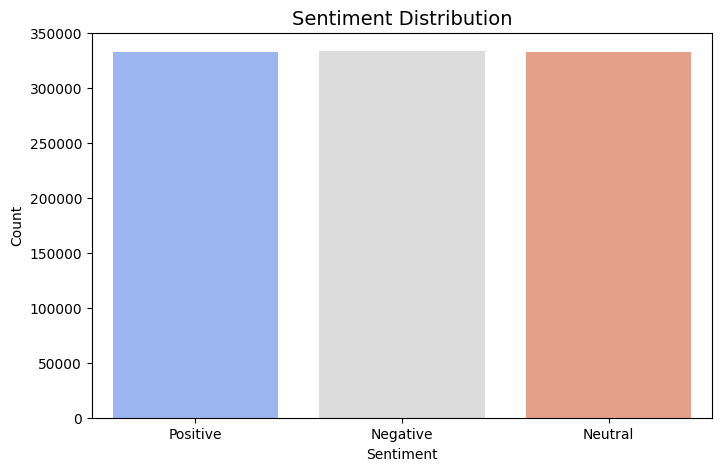

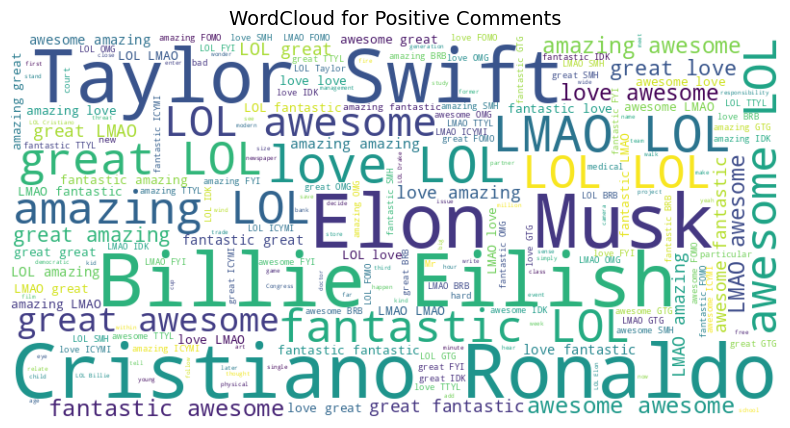

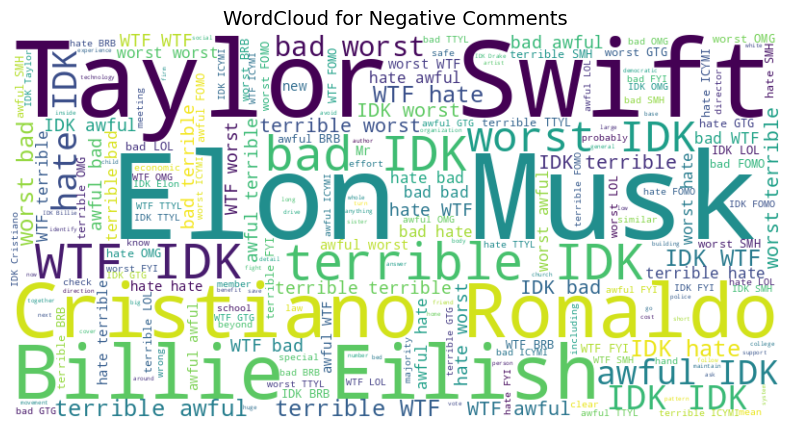

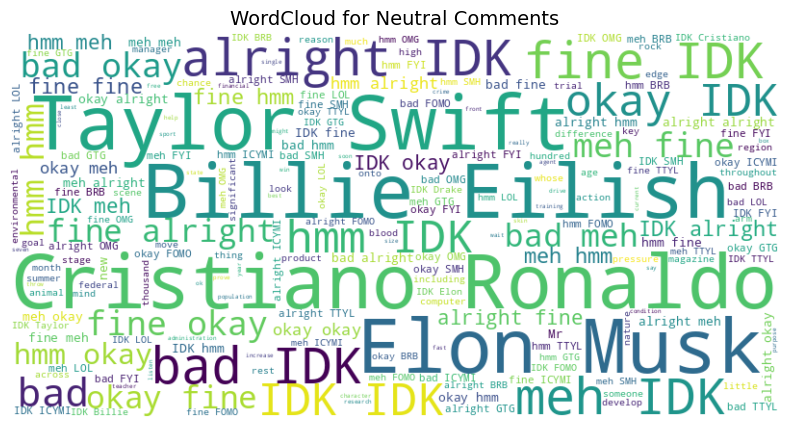

<ipython-input-8-86c4cc3b2f92>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sentiment", y="Likes", data=df, palette="coolwarm")


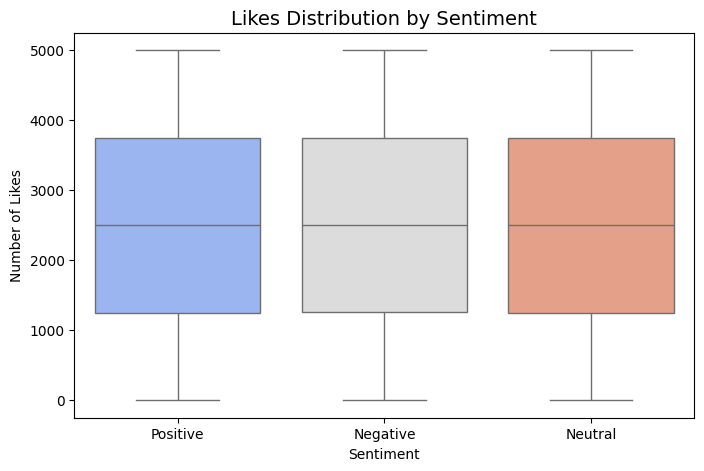

<ipython-input-8-86c4cc3b2f92>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sentiment", y="Replies", data=df, palette="coolwarm")


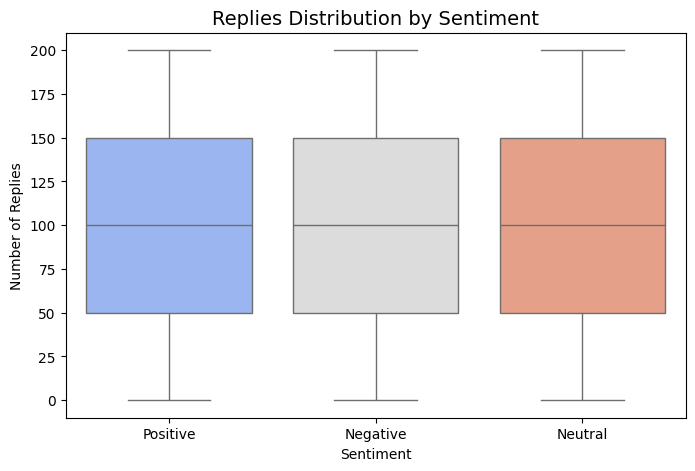

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv("large_instagram_sentiment_dataset.csv")

# Count sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Function to generate WordCloud
def generate_wordcloud(sentiment):
    text = " ".join(df[df["Sentiment"] == sentiment]["Comment"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Comments", fontsize=14)
    plt.show()

# Generate WordClouds
generate_wordcloud("Positive")
generate_wordcloud("Negative")
generate_wordcloud("Neutral")

# Sentiment & Engagement Analysis
plt.figure(figsize=(8, 5))
sns.boxplot(x="Sentiment", y="Likes", data=df, palette="coolwarm")
plt.title("Likes Distribution by Sentiment", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Likes")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x="Sentiment", y="Replies", data=df, palette="coolwarm")
plt.title("Replies Distribution by Sentiment", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Replies")
plt.show()
